In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 标模可视化
预置的人脸3D关键点可视化

In [2]:
obj, index = np.load("./model/head_pose_object_points.npy", allow_pickle=True)
obj = obj.T *10
obj[...,1] = -obj[...,1]
obj[...,0] = obj[...,0] - obj[...,0].min()+10
obj[...,1] = obj[...,1] - obj[...,1].min()+10

In [3]:
def draw_pick_kps(show_img,kps,pickidx,drawsize=2):
    kps = kps.astype('int')
    for i in range(kps.shape[0]):
        cv2.circle(show_img,(kps[i][0],kps[i][1]),drawsize,(0,255,0),-1)
    idx_count = 1
    for idx in pickidx:
        show_img = cv2.putText(show_img,str(idx_count), (kps[idx][0],kps[idx][1]), cv2.FONT_HERSHEY_SIMPLEX, 0.2*drawsize, (255, 0, 255), drawsize)
        show_img = cv2.circle(show_img,(kps[idx][0],kps[idx][1]),drawsize,(255,0,255),-1)
        idx_count = idx_count + 1
    return show_img

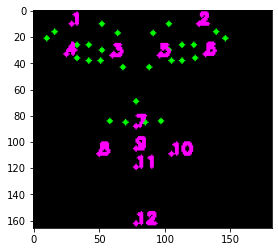

In [4]:
pick_model = [7,2, 22,18, 14,10,  30, 34,35,36,37,38]
show_img = np.zeros((int(obj[...,0].max()+20),int(obj[...,1].max()+20),3),dtype='uint8')
show_img = draw_pick_kps(show_img,obj,pick_model)
# show_img = cv2.circle(show_img,(obj[34][0],obj[34][1]),2,(255,0,0),-1)
plt.imshow(show_img/255.0)

In [5]:
obj[pick_model]

array([[ 29.64766 ,  10.      ,  66.01275 ],
       [126.870285,  10.      ,  66.01275 ],
       [ 60.359673,  34.85047 ,  44.13414 ],
       [ 25.144653,  33.933437,  39.87654 ],
       [ 96.15827 ,  34.85047 ,  44.13414 ],
       [131.37329 ,  33.933437,  39.87654 ],
       [ 78.25897 ,  88.78672 ,  67.6343  ],
       [ 50.51882 , 109.59447 ,  50.48531 ],
       [ 78.25897 , 105.25116 ,  67.04956 ],
       [105.99912 , 109.59447 ,  50.48531 ],
       [ 78.25897 , 119.950806,  60.976673],
       [ 78.25897 , 162.94363 ,  40.70434 ]], dtype=float32)

# 人脸关键点检测
opencv

In [6]:
cas = cv2.CascadeClassifier('./model/haarcascade_frontalface_alt2.xml')
facemodel = cv2.face.createFacemarkLBF()
facemodel.loadModel('./model/lbfmodel.yaml')

In [7]:
def detect_facepoint(img):
    img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = cas.detectMultiScale(img_gray,2,3,0,(30,30))
    landmarks = facemodel.fit(img_gray,faces)
    assert landmarks[0],'no face detected'
    if(len(landmarks[1])>1):
        print('multi face detected,use the first')
    return faces[0],np.squeeze(landmarks[1][0])

In [8]:
def draw_kps(img,face_box,kps):
    img_show = img.copy()
    cv2.rectangle(img_show,(face_box[0],face_box[1]),(face_box[0]+face_box[2],face_box[1]+face_box[3]),(0,255,0),3)
    for i in range(kps.shape[0]):
        cv2.circle(img_show,(kps[i,0],kps[i,1]),2,(0,255,0),-1)
    img_show = cv2.cvtColor(img_show,cv2.COLOR_BGR2RGB)
    return img_show

In [9]:
img = cv2.imread("./image/face1.jpg",-1)
box,points = detect_facepoint(img)

In [10]:
# 挑选部分关键点与标模关键点对应
pick_dlib = [19,24,39,36,42,45,33,48,51,54,57,8]

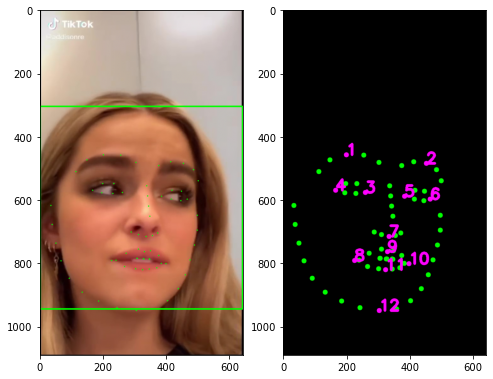

In [11]:
#可视化
show_img = draw_kps(img,box,points)
show_kps = draw_pick_kps(np.zeros_like(show_img),points,pick_dlib,drawsize=8)
plt.figure(figsize=(8,8))
plt.subplot(121)
plt.imshow(show_img/255.0)
plt.subplot(122)
plt.imshow(show_kps/255.0)

# 计算朝向

In [12]:
H,W = img.shape[0],img.shape[1]
matrix = np.array([[W,0,W/2.0],[0,W,H/2.0],[0,0,1]])
_,rot_vec,trans_vec = cv2.solvePnP(obj[pick_model,...].astype("float32"),points[pick_dlib,...].astype("float32"),matrix,None,flags=cv2.SOLVEPNP_DLS)

In [14]:
rot_mat = cv2.Rodrigues(rot_vec)[0]
pose_mat = cv2.hconcat((rot_mat, trans_vec))
euler_angle = cv2.decomposeProjectionMatrix(pose_mat)[-1]
euler_angle = euler_angle.flatten()

In [ ]:
print(euler_angle)

In [15]:
def draw_axis(img, euler_angle, center, size=80, thickness=3,
                  angle_const=np.pi/180, copy=False):
        if copy:
            img = img.copy()

        euler_angle *= angle_const
        sin_pitch, sin_yaw, sin_roll = np.sin(euler_angle)
        cos_pitch, cos_yaw, cos_roll = np.cos(euler_angle)

        axis = np.array([
            [cos_yaw * cos_roll,
             cos_pitch * sin_roll + cos_roll * sin_pitch * sin_yaw],
            [-cos_yaw * sin_roll,
             cos_pitch * cos_roll - sin_pitch * sin_yaw * sin_roll],
            [sin_yaw,
             -cos_yaw * sin_pitch]
        ])

        axis *= size
        axis += center

        axis = axis.astype(np.int)
        tp_center = tuple(center.astype(np.int))

        cv2.line(img, tp_center, tuple(axis[0]), (0, 0, 255), thickness)
        cv2.line(img, tp_center, tuple(axis[1]), (0, 255, 0), thickness)
        cv2.line(img, tp_center, tuple(axis[2]), (255, 0, 0), thickness)

        return img


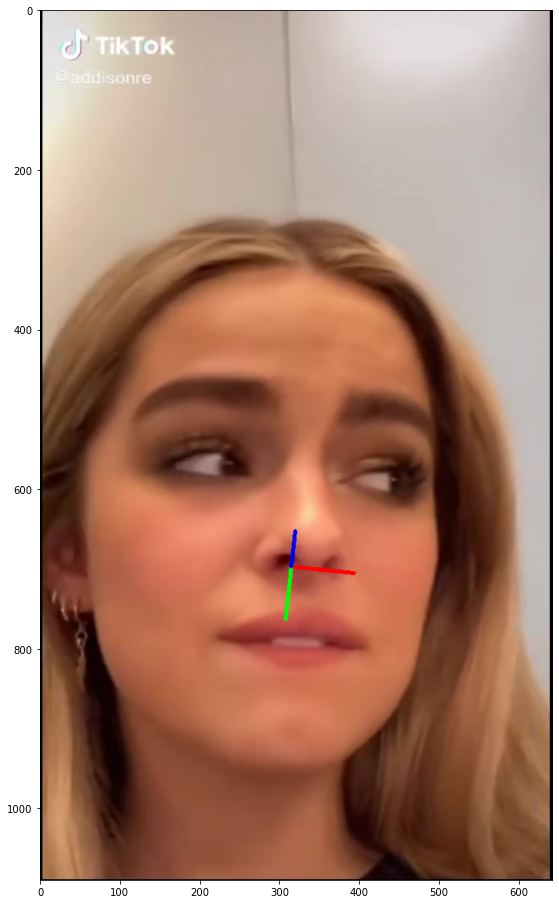

In [16]:
show_img = draw_axis(img,euler_angle,np.mean(points,axis=0))
plt.figure(figsize=(16,16))
plt.imshow(show_img[...,::-1]/255.0)